# Subtype predictor -- single cell QC

In this file I will QC the HGSC single cell data from 

cell type calls are from: https://github.com/greenelab/deconvolution_pilot/tree/main/data/cell_labels

data is from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217517

only the 8 single-cell samples (4 samples 2 replicates)

manuscript of data: Hippen AA, Omran DK, Weber LM, Jung E et al. Performance of computational algorithms to deconvolve heterogeneous bulk ovarian tumor tissue depends on experimental factors. Genome Biol 2023 Oct 20;24(1):239. PMID: 37864274


I will make the typical QC plots, then write it out for making pseudobulks

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from matplotlib.pyplot import rc_context

import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

data_path = f"{os.getcwd()}/../../data/single_cell/"

result_ad_file = f"{data_path}/HGSCsubtype_processed.h5ad"
result_bp_file = f"{data_path}/HGSCsubtype_processed_temp.tsv"
result_cs_file = f"{data_path}/HGSCsubtypec_processed_cibersort.tsv"
output_BP = True

scanpy==1.10.4 anndata==0.11.1 umap==0.5.2 numpy==2.0.2 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.6.0 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [3]:
# read in the expression
all_samps = ["GSM6720925", "GSM6720926", "GSM6720927", 
               "GSM6720928", "GSM6720929", "GSM6720930",
               "GSM6720931", "GSM6720932"]

all_adata = None
for curr_samp in all_samps:
    adata_0 = sc.read_10x_mtx(f"{data_path}/GSE217517_RAW/{curr_samp}")
    adata_0.obs["GSM"] = curr_samp
    if all_adata is None:
        all_adata = adata_0
    else:
        all_adata = ad.concat([all_adata, adata_0])

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/Users/davidnat/Documents/projects/davidsonlab/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/Users/davidnat/Documents/projects/davidsonlab/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/Users/davidnat/Documents/projects/davidsonlab/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/Users/davidnat/Documents/projects/davidsonlab/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/Users/davidnat/Documents/projects/davidsonlab/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/Users/davidnat/Documents/projects/davidsonlab/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/davidnat/Documents/projects/davidsonlab/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# format metadata

In [4]:
# read in the metadata
meta_cell_path = f"{data_path}/GSE217517_metadata/GSE217517_cell_metadata.tsv"
meta_subtype_path = f"{data_path}/GSE217517_metadata/GSE217517_cell_subtypes.tsv"
meta_samp_path = f"{data_path}/GSE217517_metadata/GSE217517_sample_metadata.csv"

# read in tables
meta_cell_df = pd.read_csv(meta_cell_path, sep="\t")
meta_samp_df = pd.read_csv(meta_samp_path)
meta_subtype_df = pd.read_csv(meta_subtype_path, sep="\t")

# remove unknown cell types
meta_cell_df = meta_cell_df[~meta_cell_df.cellType.isin(["Unknown1", "Unknown2"])]


# format the subtype metadata
meta_subtype_df.drop('samp_id', axis=1, inplace=True)
meta_subtype_df["max_consensusOV"]=meta_subtype_df[["IMR_consensus", "DIF_consensus", "PRO_consensus", "MES_consensus"]].max(axis=1) 


# merge the metadata
meta_cell_df.index = meta_cell_df["Barcode"]
merged_df = all_adata.obs.join(meta_cell_df, how='inner')
merged_df = pd.merge(merged_df, meta_samp_df, left_on='samp_id', right_on='samp_id')
merged_df = pd.merge(merged_df, meta_subtype_df, left_on=['Barcode', "gse_id"], right_on=['Barcode', "gse_id"])

# remove duplicates
cell_barcode_keep = pd.Series(merged_df["Barcode"]).drop_duplicates(keep=False)
merged_df = merged_df.iloc[np.where(merged_df["Barcode"].isin(cell_barcode_keep))[0]]
all_adata = all_adata[np.where(all_adata.obs.index.isin(cell_barcode_keep))[0],:]

# order the obs in the same order
merged_df.index = merged_df["Barcode"]
left_df, right_df = merged_df.align(all_adata.obs, join="inner", axis=0)
left_df

merged_df.index = merged_df["Barcode"]

#inner: use intersection of keys from both frames, preserve the order of the left keys.
left_df, right_df = all_adata.obs.align(merged_df, join="inner", axis=0)

# now keeping the same ordering as the original obs
# replace the obs DF
all_adata = all_adata[left_df.index, :]
all_adata.obs = right_df


In [5]:
# format metadata

# reformat the cell types to be more granular
cell_type_vec = all_adata.obs['cellType'].copy()
immune_idx = np.where(cell_type_vec.isin(["B cells", "DC", "Erythroid", "ILC", "Macrophages", 
                                           "Mast cells", "Monocytes", "NK cells", "Plasma cells",
                                           "T cells", "pDC"]) )[0]
cell_type_vec[immune_idx] = "immune"

stromal_idx = np.where(cell_type_vec.isin(["Endothelial cells", "Fibroblasts"]) )[0]
cell_type_vec[stromal_idx] = "stromal"

epi_idx = np.where(cell_type_vec.isin(["Epithelial cells"]) )[0]
cell_type_vec[epi_idx] = "tumor"
all_adata.obs['celltype_granular'] = cell_type_vec



all_adata.obs['scpred_CellType'] = all_adata.obs['cellType']

all_adata.obs['sample_id'] = 'Samp_' + all_adata.obs['samp_id'].astype(str)
all_adata.obs['sample_id'] = all_adata.obs['sample_id'].tolist()
all_adata.obs['stim'] = ["CTRL"]*len(all_adata.obs)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_56821/318558725.py:8: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  cell_type_vec[immune_idx] = "immune"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_56821/318558725.py:11: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  cell_type_vec[stromal_idx] = "stromal"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_56821/318558725.py:14: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by po

In [10]:
tab = all_adata.obs.iloc[np.where(all_adata.obs.cellType == "Epithelial cells")[0]].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype       DIF   IMR   MES    PRO
sample_id                           
Samp_2251   538.0   3.0   5.0    NaN
Samp_2267   458.0   2.0  20.0  327.0
Samp_2283  1679.0  24.0  18.0   86.0
Samp_2293   240.0   NaN   1.0   29.0
Samp_2380   769.0   4.0  52.0   45.0
Samp_2428    32.0   NaN   3.0   11.0
Samp_2467   227.0   NaN   7.0    2.0
Samp_2497   979.0   9.0   7.0   23.0

In [6]:
tab = all_adata.obs.groupby(['cellType', 'subtype']).size()
tab.unstack()

subtype               DIF     IMR     MES     PRO
cellType                                         
B cells             644.0   159.0   125.0    37.0
DC                  267.0   421.0    33.0    58.0
Endothelial cells  1892.0    84.0   100.0   307.0
Epithelial cells   4922.0    42.0   113.0   523.0
Erythroid             4.0     1.0     NaN     NaN
Fibroblasts        3283.0   219.0  6205.0  1010.0
ILC                 141.0    37.0     1.0     NaN
Macrophages         598.0  3284.0   227.0    20.0
Mast cells          110.0     8.0     6.0     4.0
Monocytes           413.0   951.0    85.0     2.0
NK cells           1005.0   502.0   213.0   199.0
Plasma cells       1968.0   416.0    68.0    95.0
T cells            8882.0  2943.0  1465.0  1705.0
pDC                 297.0   106.0    38.0   106.0

In [7]:
tab = all_adata.obs.groupby(['celltype_granular', 'subtype']).size()
tab.unstack()

subtype              DIF   IMR   MES   PRO
celltype_granular                         
immune             14329  8828  2261  2226
stromal             5175   303  6305  1317
tumor               4922    42   113   523

In [8]:
tab = all_adata.obs.iloc[np.where(all_adata.obs.max_consensusOV > 0.4)[0]].groupby(['celltype_granular', 'subtype']).size()
tab.unstack()

subtype              DIF   IMR   MES  PRO
celltype_granular                        
immune             10079  7059   238  819
stromal             2779    75  4287  314
tumor               4538    21    29  360

In [9]:
all_adata.var.index

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

In [10]:
# remove genes that are duplicated
all_adata.var["gene_ids"] = all_adata.var.index.to_list()
a = (all_adata.var['gene_ids'].value_counts() == 1)
a = a[a].keys().to_list()
unique_genes = np.unique(a)

all_adata = all_adata[:, all_adata.var['gene_ids'].isin(unique_genes)]

# make the common name the index
all_adata.var.index = all_adata.var['gene_ids']


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_42975/4168681709.py:10: ImplicitModificationWarning: Trying to modify index of attribute `.var` of view, initializing view as actual.
  all_adata.var.index = all_adata.var['gene_ids']


# QC everything

In [11]:
# how many of each samp
all_adata.obs["sample_id"].value_counts()

sample_id
Samp_2293    8852
Samp_2497    7803
Samp_2251    7241
Samp_2283    6276
Samp_2380    5610
Samp_2467    5468
Samp_2267    4870
Samp_2428     224
Name: count, dtype: int64

In [12]:
# see cell types, we will merge some
tab = all_adata.obs.groupby(['scpred_CellType', 'sample_id']).size()

tab.unstack()

sample_id          Samp_2251  Samp_2267  Samp_2283  Samp_2293  Samp_2380  \
scpred_CellType                                                            
B cells                168.0      208.0        NaN       48.0      179.0   
DC                     143.0      201.0        NaN      171.0      161.0   
Endothelial cells     1234.0       36.0      113.0       32.0      184.0   
Epithelial cells       546.0      807.0     1807.0      270.0      870.0   
Erythroid                NaN        NaN        NaN        NaN        NaN   
Fibroblasts           1300.0      131.0     1949.0      213.0     1443.0   
ILC                     60.0        NaN        NaN        NaN       59.0   
Macrophages            268.0      424.0     1449.0      909.0      233.0   
Mast cells              20.0        4.0        NaN       11.0       21.0   
Monocytes              292.0      180.0      256.0       42.0      450.0   
NK cells               201.0      265.0      139.0     1017.0      140.0   
Plasma cells          1931.0       26.0        NaN      129.0       35.0   
T cells               1012.0     2492.0      563.0     5760.0     1700.0   
pDC                     66.0       96.0        NaN      250.0      135.0   

sample_id          Samp_2428  Samp_2467  Samp_2497  
scpred_CellType                                     
B cells                  NaN       24.0      338.0  
DC                       NaN       30.0       73.0  
Endothelial cells        9.0      414.0      361.0  
Epithelial cells        46.0      236.0     1018.0  
Erythroid                NaN        NaN        5.0  
Fibroblasts             15.0     2982.0     2684.0  
ILC                      NaN        NaN       60.0  
Macrophages             30.0      655.0      161.0  
Mast cells               NaN       32.0       40.0  
Monocytes                NaN      169.0       62.0  
NK cells                54.0       62.0       41.0  
Plasma cells            12.0      358.0       56.0  
T cells                 58.0      506.0     2904.0  
pDC                      NaN        NaN        NaN

In [13]:
# remove Erythroid and ILC and pDC
ct_idx = all_adata.obs.scpred_CellType.isin(["Erythroid", "ILC", "pDC"])
inverted_list = [not x for x in ct_idx]
all_adata = all_adata[np.where(inverted_list)[0]]

tab = all_adata.obs.groupby(['scpred_CellType', 'sample_id']).size()
tab.unstack()

sample_id          Samp_2251  Samp_2267  Samp_2283  Samp_2293  Samp_2380  \
scpred_CellType                                                            
B cells                168.0      208.0        NaN       48.0      179.0   
DC                     143.0      201.0        NaN      171.0      161.0   
Endothelial cells     1234.0       36.0      113.0       32.0      184.0   
Epithelial cells       546.0      807.0     1807.0      270.0      870.0   
Fibroblasts           1300.0      131.0     1949.0      213.0     1443.0   
Macrophages            268.0      424.0     1449.0      909.0      233.0   
Mast cells              20.0        4.0        NaN       11.0       21.0   
Monocytes              292.0      180.0      256.0       42.0      450.0   
NK cells               201.0      265.0      139.0     1017.0      140.0   
Plasma cells          1931.0       26.0        NaN      129.0       35.0   
T cells               1012.0     2492.0      563.0     5760.0     1700.0   

sample_id          Samp_2428  Samp_2467  Samp_2497  
scpred_CellType                                     
B cells                  NaN       24.0      338.0  
DC                       NaN       30.0       73.0  
Endothelial cells        9.0      414.0      361.0  
Epithelial cells        46.0      236.0     1018.0  
Fibroblasts             15.0     2982.0     2684.0  
Macrophages             30.0      655.0      161.0  
Mast cells               NaN       32.0       40.0  
Monocytes                NaN      169.0       62.0  
NK cells                54.0       62.0       41.0  
Plasma cells            12.0      358.0       56.0  
T cells                 58.0      506.0     2904.0

In [14]:
# remove samples Samp_2428Samp_2267 and Samp_2283
ct_idx = all_adata.obs.sample_id.isin(["Samp_2428", "Samp_2283", "Samp_2267"])
inverted_list = [not x for x in ct_idx]
all_adata = all_adata[np.where(inverted_list)[0]]

tab = all_adata.obs.groupby(['scpred_CellType', 'sample_id']).size()
tab.unstack()

sample_id          Samp_2251  Samp_2293  Samp_2380  Samp_2467  Samp_2497
scpred_CellType                                                         
B cells                  168         48        179         24        338
DC                       143        171        161         30         73
Endothelial cells       1234         32        184        414        361
Epithelial cells         546        270        870        236       1018
Fibroblasts             1300        213       1443       2982       2684
Macrophages              268        909        233        655        161
Mast cells                20         11         21         32         40
Monocytes                292         42        450        169         62
NK cells                 201       1017        140         62         41
Plasma cells            1931        129         35        358         56
T cells                 1012       5760       1700        506       2904

normalizing counts per cell


/Users/davidnat/Documents/projects/davidsonlab/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


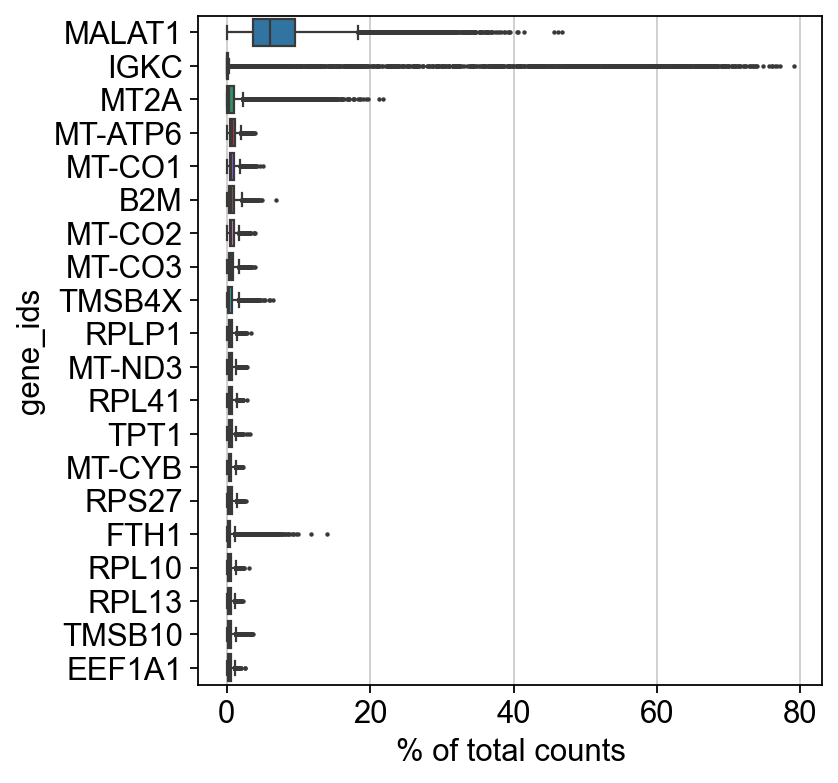

In [15]:
sc.pl.highest_expr_genes(all_adata, n_top=20, )


In [16]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(all_adata, min_genes=500)
sc.pp.filter_genes(all_adata, min_cells=3)


filtered out 4 cells that have less than 500 genes expressed
filtered out 5423 genes that are detected in less than 3 cells


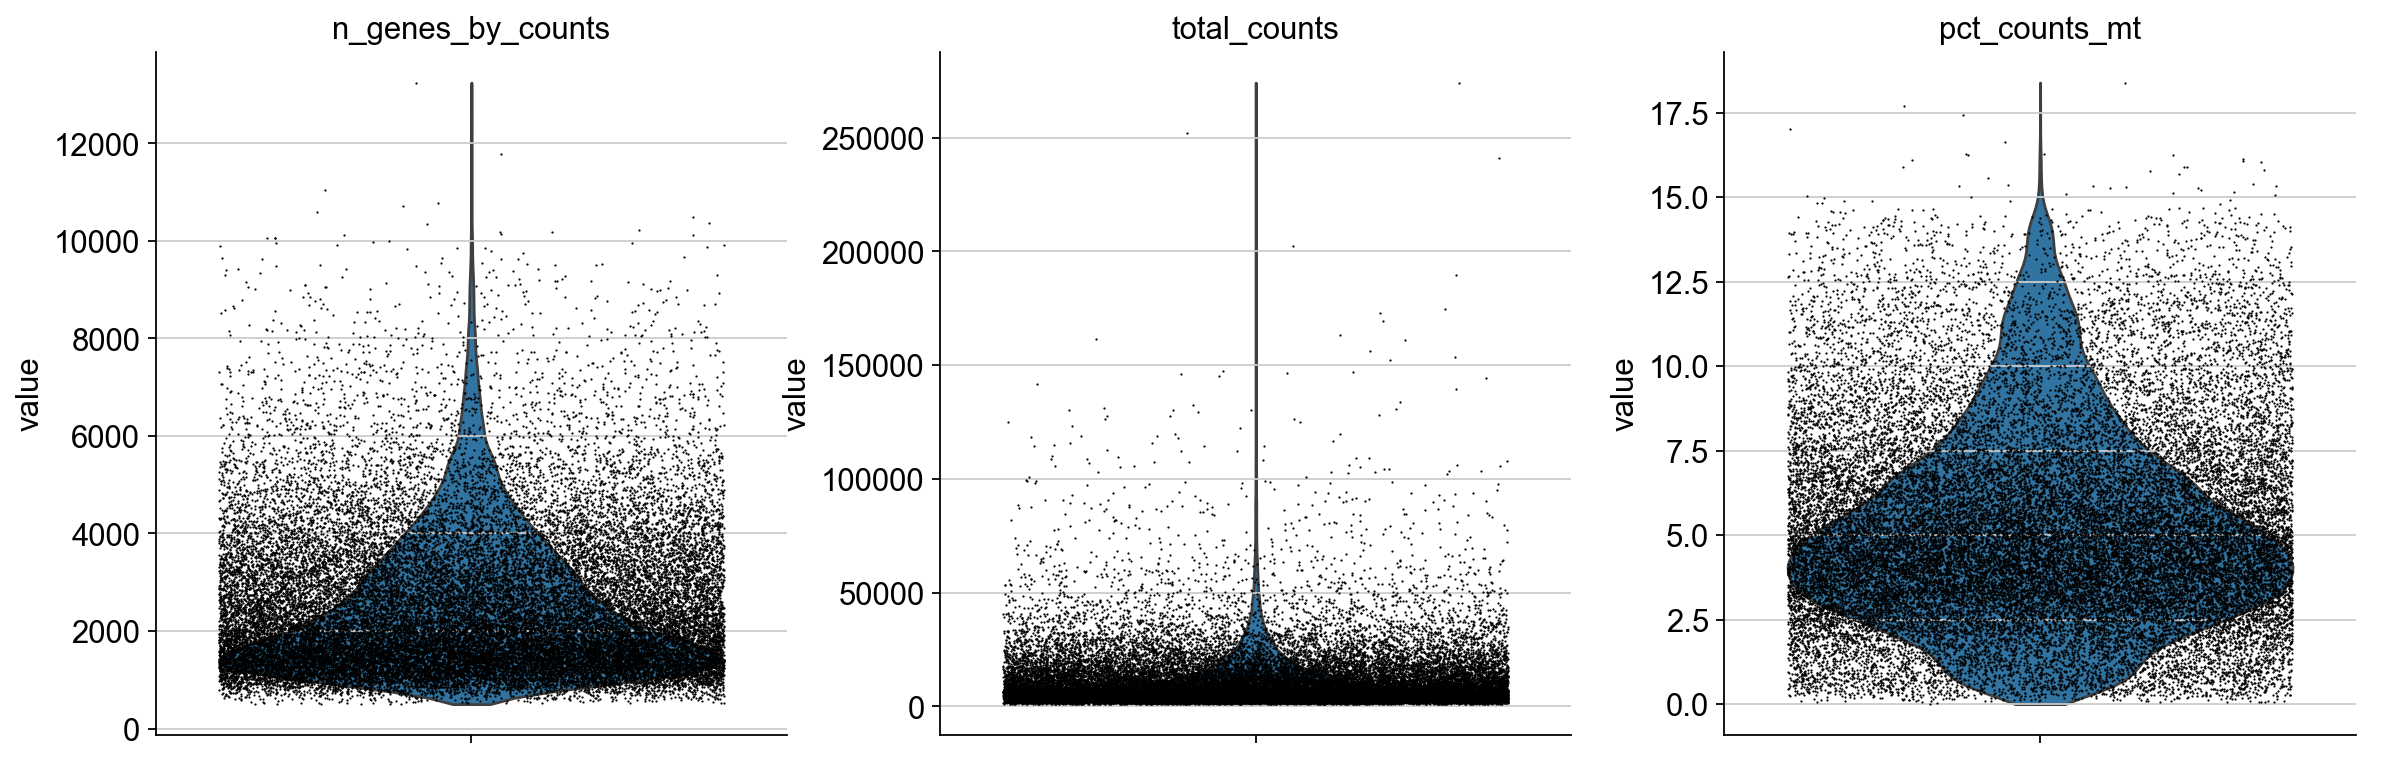

In [17]:
# remove genes with high mitochondrial content
all_adata.var['mt'] = all_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(all_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(all_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

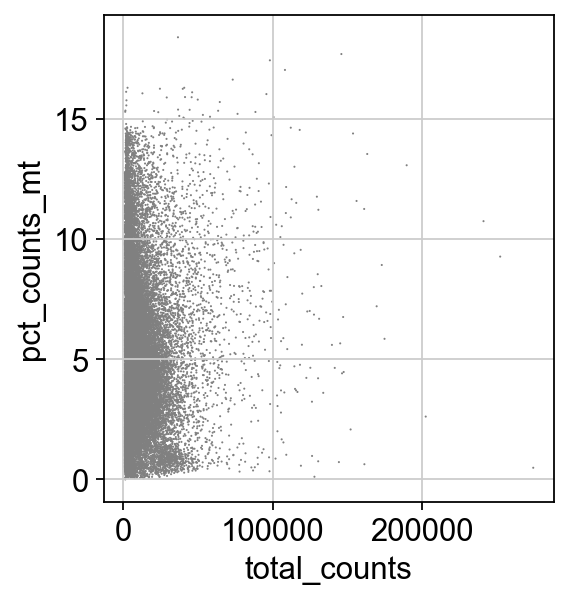

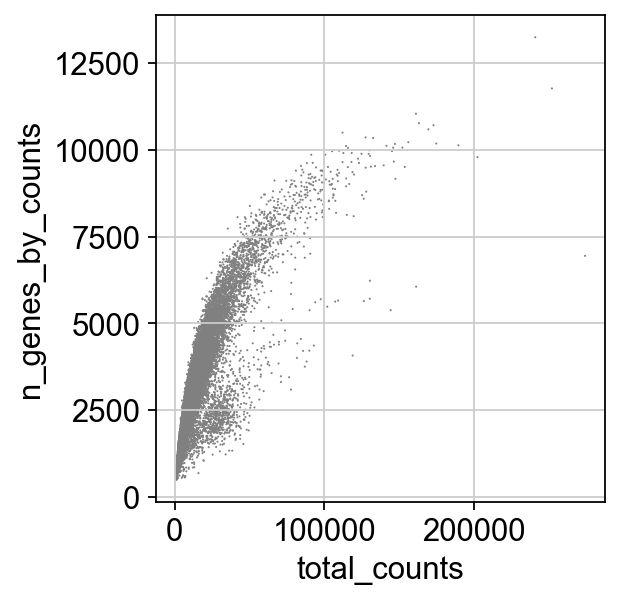

In [18]:
sc.pl.scatter(all_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(all_adata, x='total_counts', y='n_genes_by_counts')

In [19]:
# slice the data based on the plots from above
# remove cells with more than 7000 genes
# remove cells with more than 10% MTgenes
all_adata = all_adata[all_adata.obs.n_genes_by_counts < 10000, :]
all_adata = all_adata[all_adata.obs.pct_counts_mt < 10, :]

normalizing counts per cell


/Users/davidnat/Documents/projects/davidsonlab/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


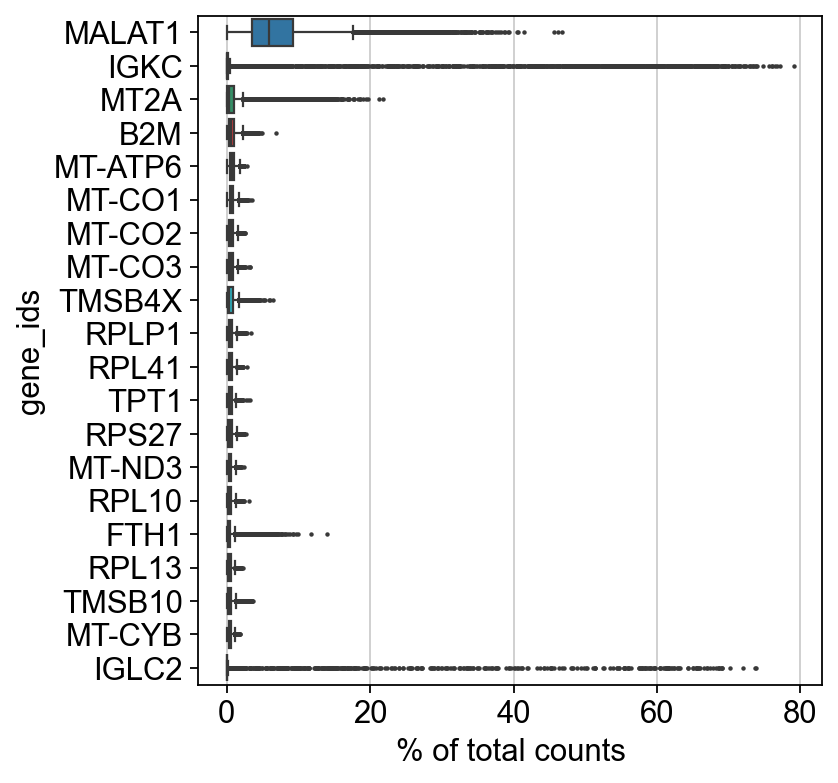

In [20]:
sc.pl.highest_expr_genes(all_adata, n_top=20, )


## write it out

In [21]:
result_ad_file

'/Users/davidnat/Documents/projects/davidsonlab/projects/proportion_subtype_predictor/code/../data/single_cell//HGSCsubtype_processed.h5ad'

In [22]:
# process the BP input file
bp_df = pd.DataFrame(all_adata.X.todense())
bp_df.columns = all_adata.var.gene_ids
bp_df["cell_type"] = all_adata.obs.scpred_CellType.to_list()

# stratified subsample
strat_str = all_adata.obs.scpred_CellType.astype(str) + all_adata.obs.sample_id.astype(str)
strat_str = strat_str.to_list()
bp_df["strat"] = strat_str
bp_df_subsampled = bp_df.groupby('strat', group_keys=False).apply(lambda x: x.sample(frac=0.2))

bp_df_subsampled.cell_type.value_counts()


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_42975/2865582338.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bp_df_subsampled = bp_df.groupby('strat', group_keys=False).apply(lambda x: x.sample(frac=0.2))


cell_type
T cells              2199
Fibroblasts          1629
Plasma cells          486
Epithelial cells      459
Endothelial cells     419
Macrophages           405
NK cells              276
Monocytes             189
B cells               136
DC                    107
Mast cells             19
Name: count, dtype: int64

In [131]:
# write it out before normalization
all_adata.write(result_ad_file)

# write out for bayesprism
if output_BP:
    bp_df_subsampled.to_csv(result_bp_file, sep="\t")


In [132]:
# write out for cibersort

bp_df_subsampled_ciber = bp_df_subsampled.copy()
bp_df_subsampled_ciber = bp_df_subsampled_ciber.drop('strat', axis=1)
bp_df_subsampled_ciber = bp_df_subsampled_ciber.drop('cell_type', axis=1)
bp_df_subsampled_ciber = bp_df_subsampled_ciber.T
bp_df_subsampled_ciber.columns = bp_df_subsampled.cell_type

bp_df_subsampled_ciber.to_csv(result_cs_file, sep="\t")

# Normalization

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


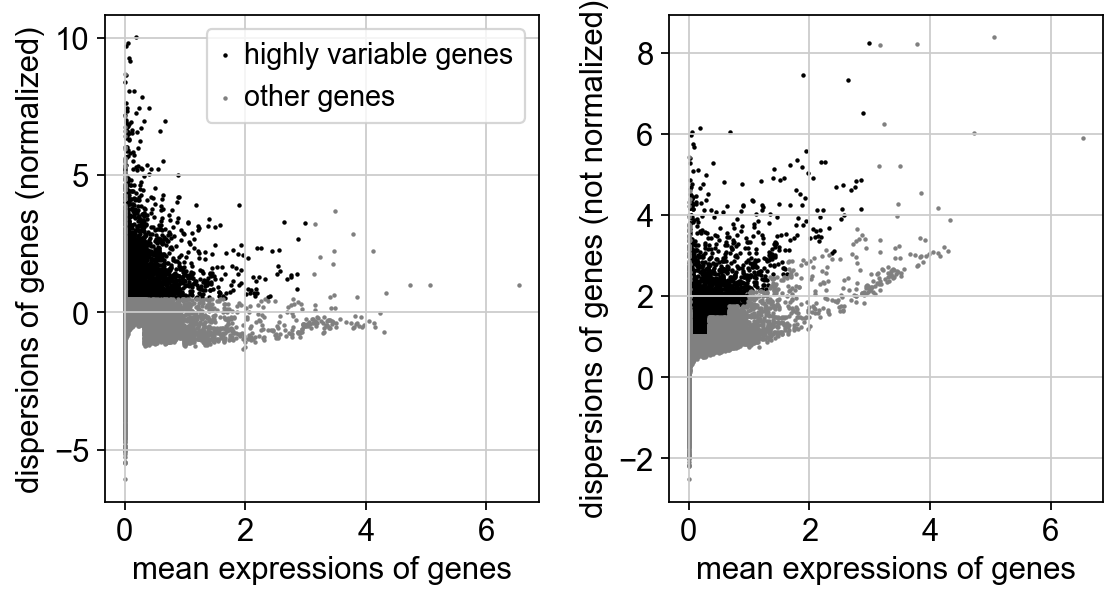

In [23]:
# normalize to 10K counts per cell
sc.pp.normalize_total(all_adata, target_sum=1e4)

# log data
sc.pp.log1p(all_adata)

# get high variance genes
sc.pp.highly_variable_genes(all_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(all_adata)

# now store the raw version of the data for our use later
all_adata.raw = all_adata


In [24]:
# now process the counts further for doing DE 
# analysis and the cell clustering
all_adata = all_adata[:, all_adata.var.highly_variable]

# regress out the signal
sc.pp.regress_out(all_adata, ['total_counts', 'pct_counts_mt'])

# scale the genes
sc.pp.scale(all_adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']


/Users/davidnat/Documents/projects/davidsonlab/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    sparse input is densified and may lead to high memory use
    finished (0:01:19)


# PCA

computing PCA
    with n_comps=50
    finished (0:00:10)


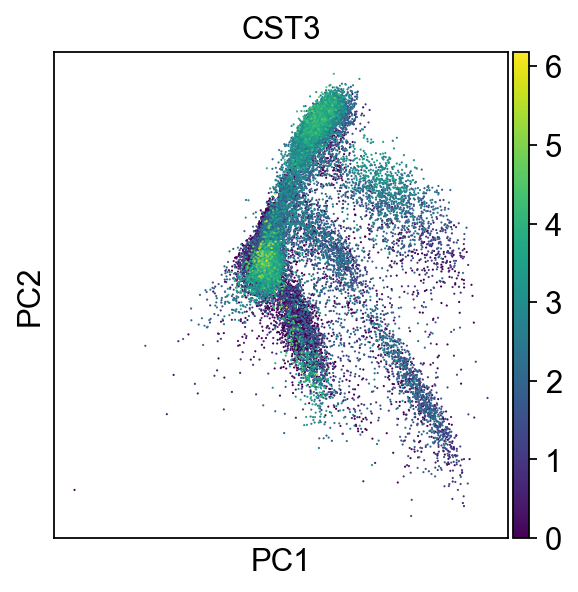

In [25]:
sc.tl.pca(all_adata, n_comps=50)
sc.pl.pca(all_adata, color='CST3')


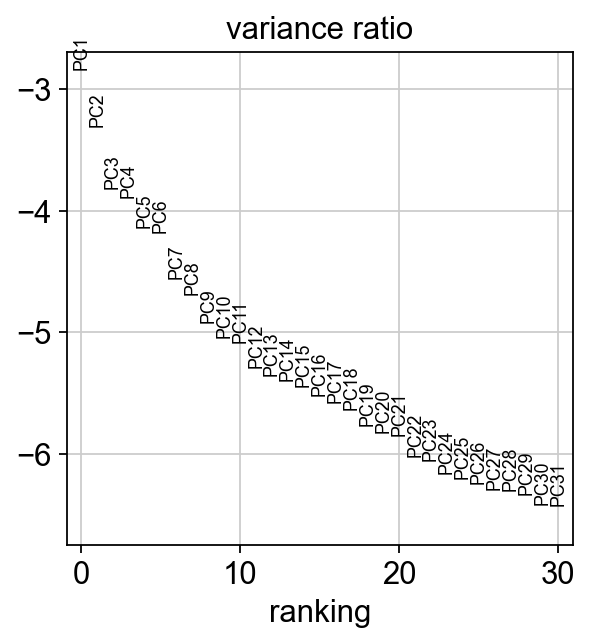

In [26]:
sc.pl.pca_variance_ratio(all_adata, log=True)


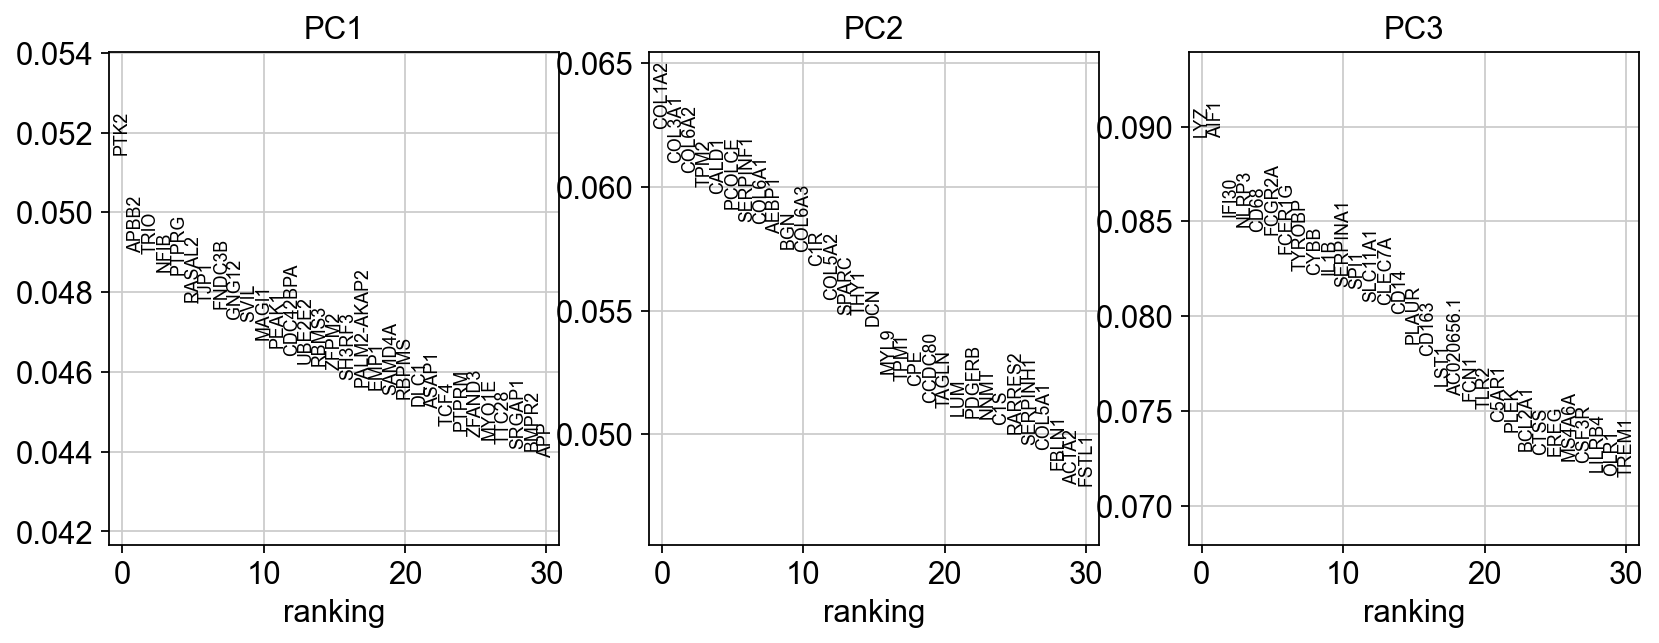

In [27]:
sc.pl.pca_loadings(all_adata, include_lowest=False)


## Compute and embed neighborhood graph

In [28]:
# valculate neighborhood graph
sc.pp.neighbors(all_adata)

# make umap
sc.tl.umap(all_adata)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)


## Cluster the neighborhood graph

running Leiden clustering


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_42975/2557792080.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(all_adata, resolution=0.7)


    finished: found 34 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:07)


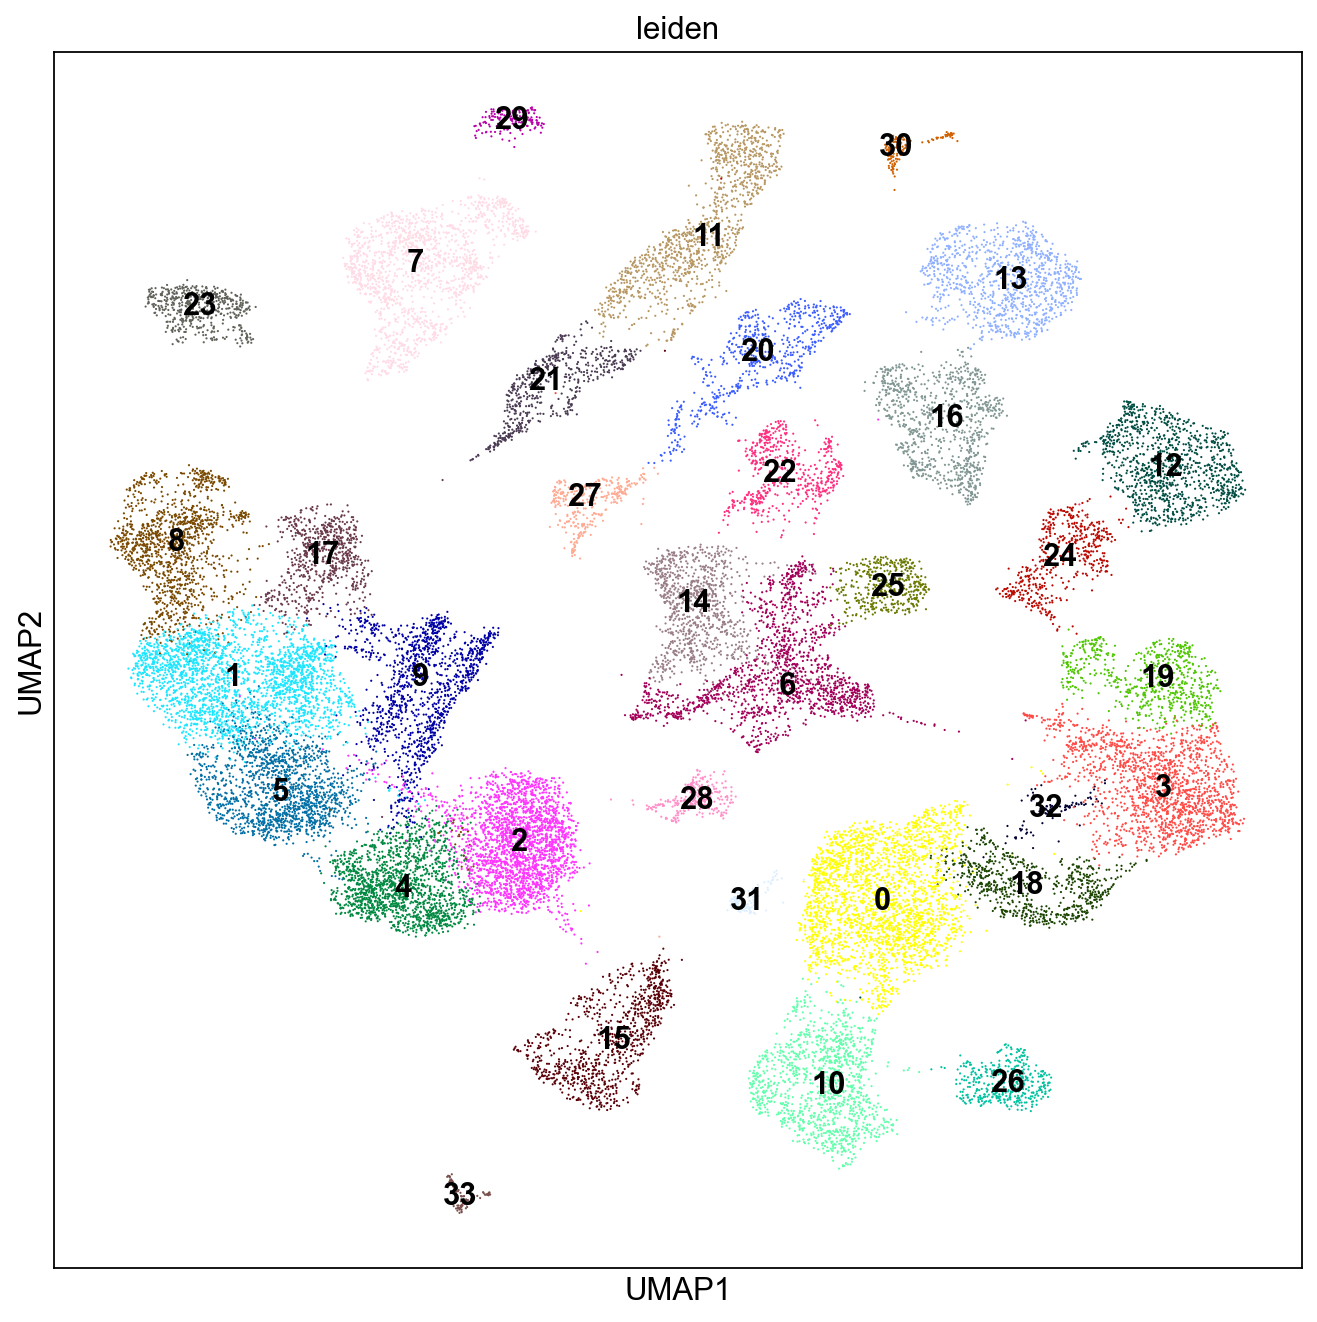

In [29]:
# lets use Leiden clustering
sc.tl.leiden(all_adata, resolution=0.7)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='leiden', legend_loc='on data')



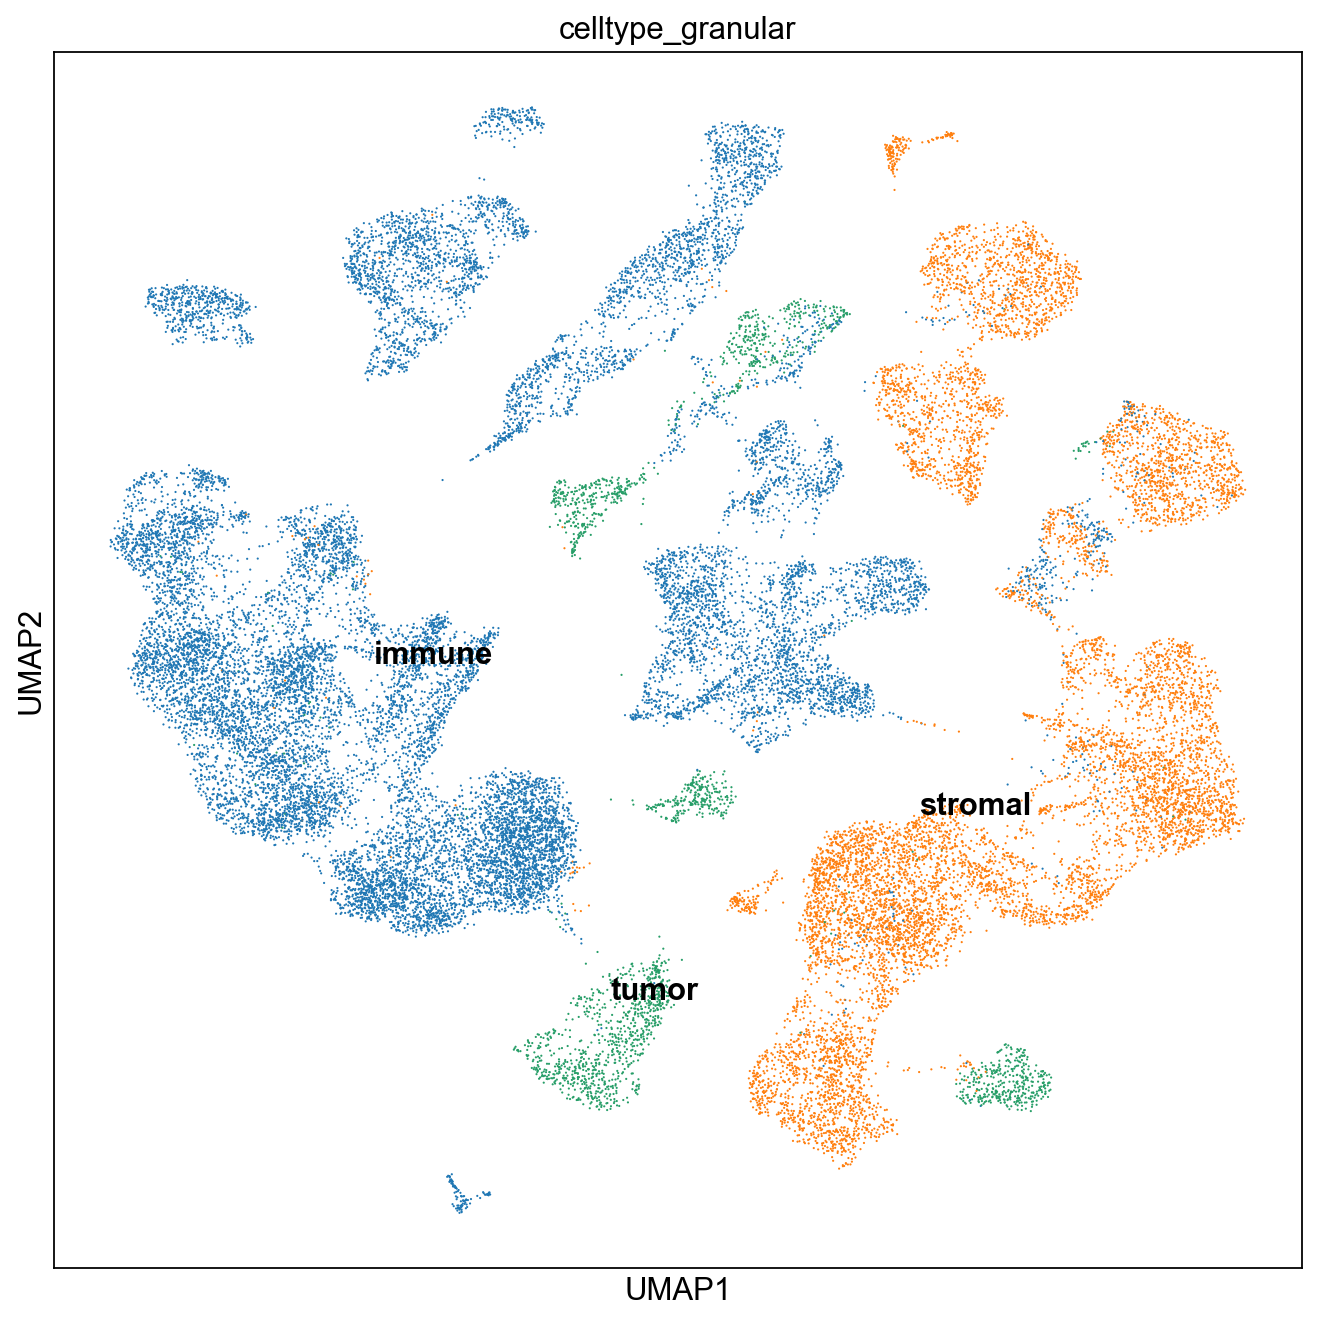

In [30]:
# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='celltype_granular', legend_loc='on data')


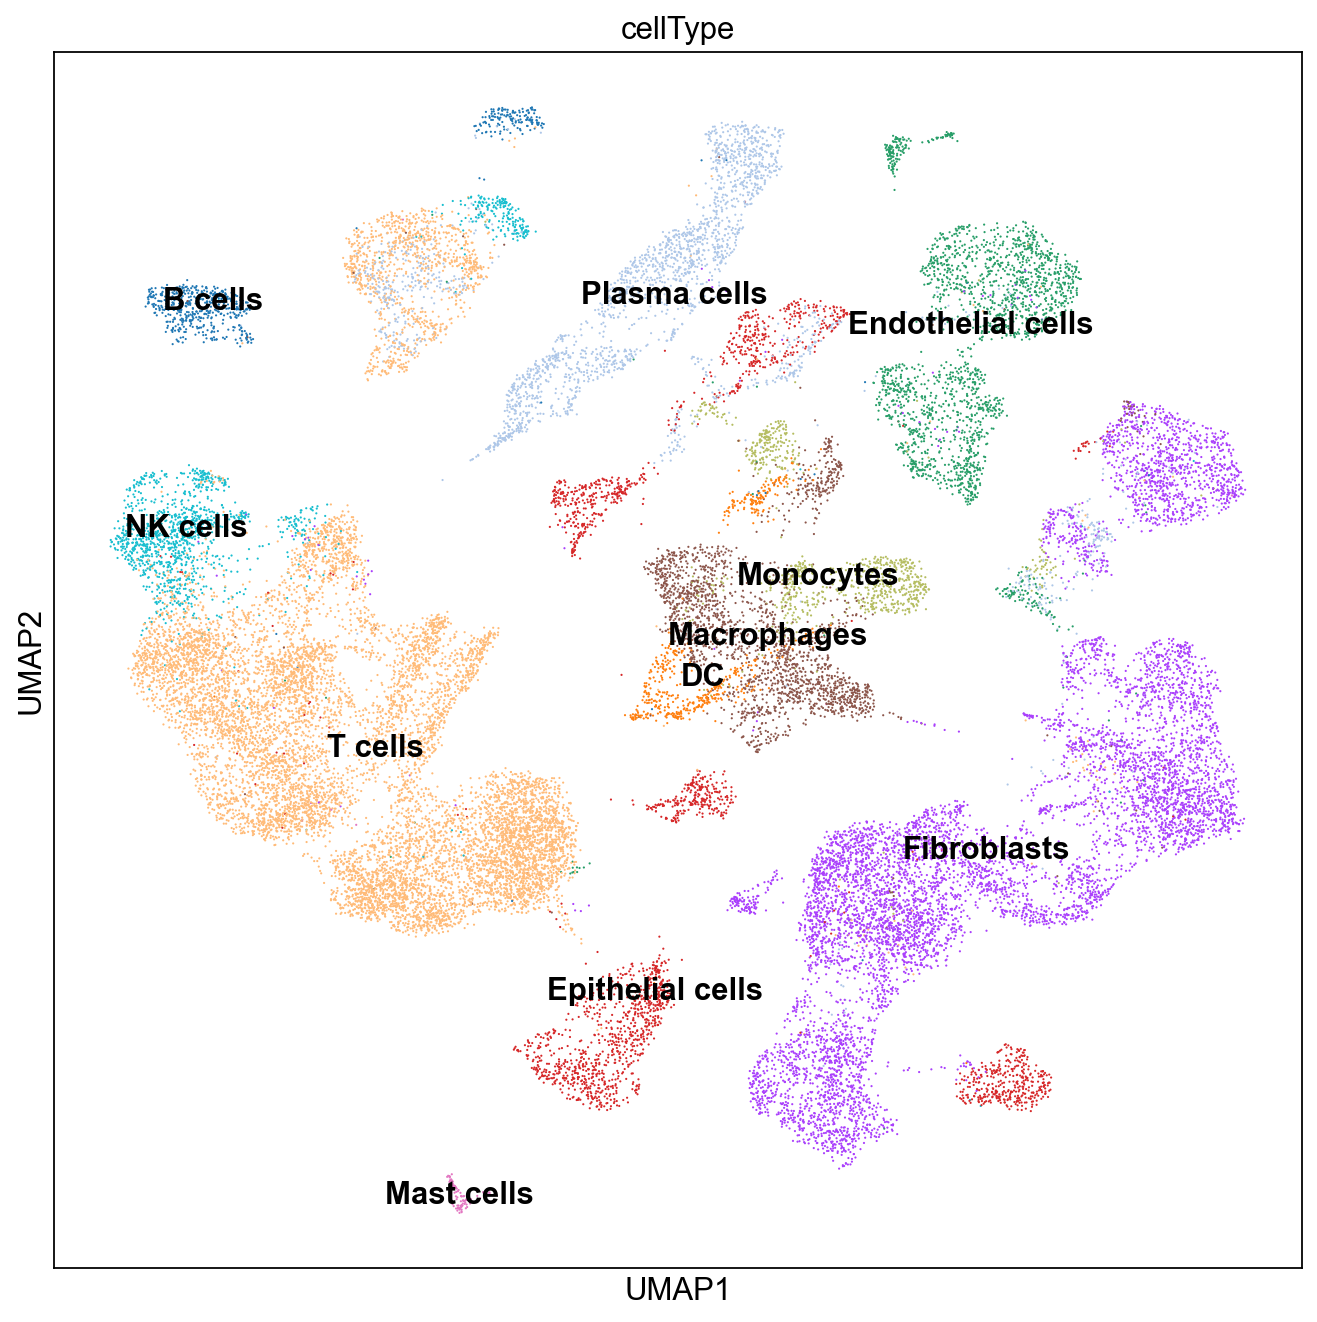

In [31]:
# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='cellType', legend_loc='on data')


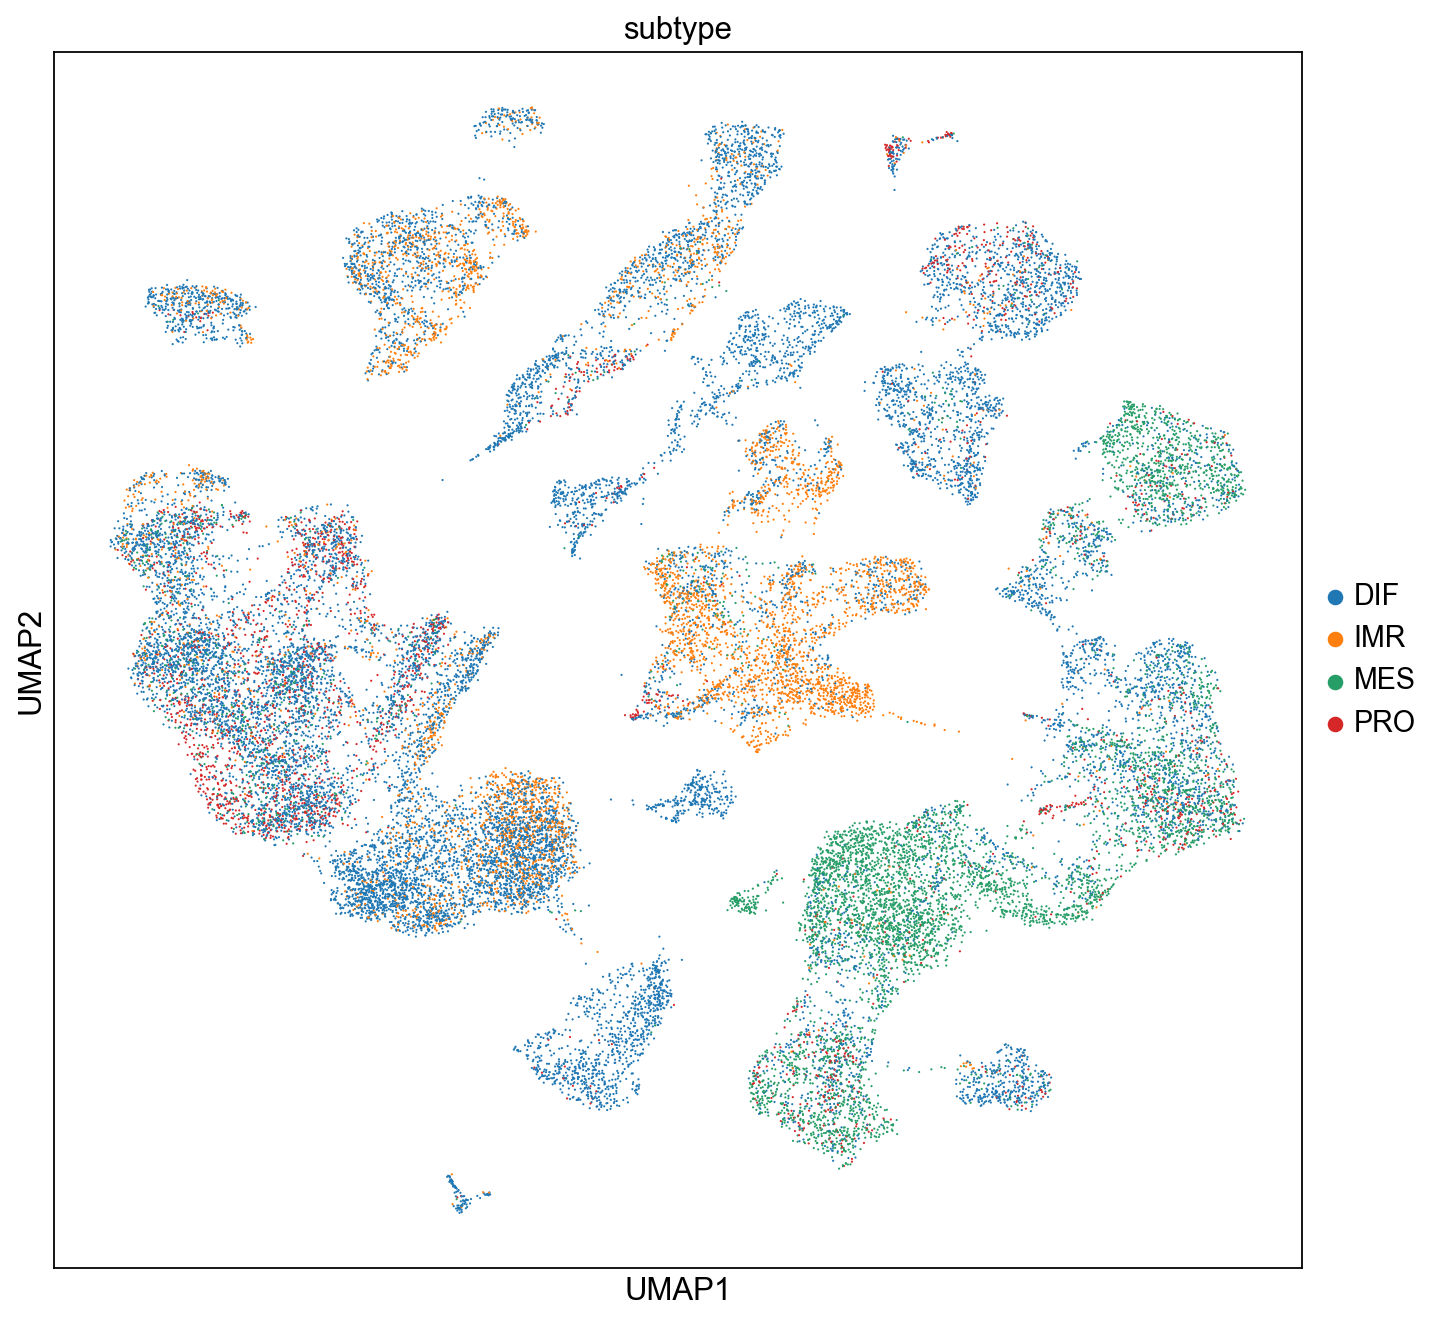

In [32]:
# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='subtype')


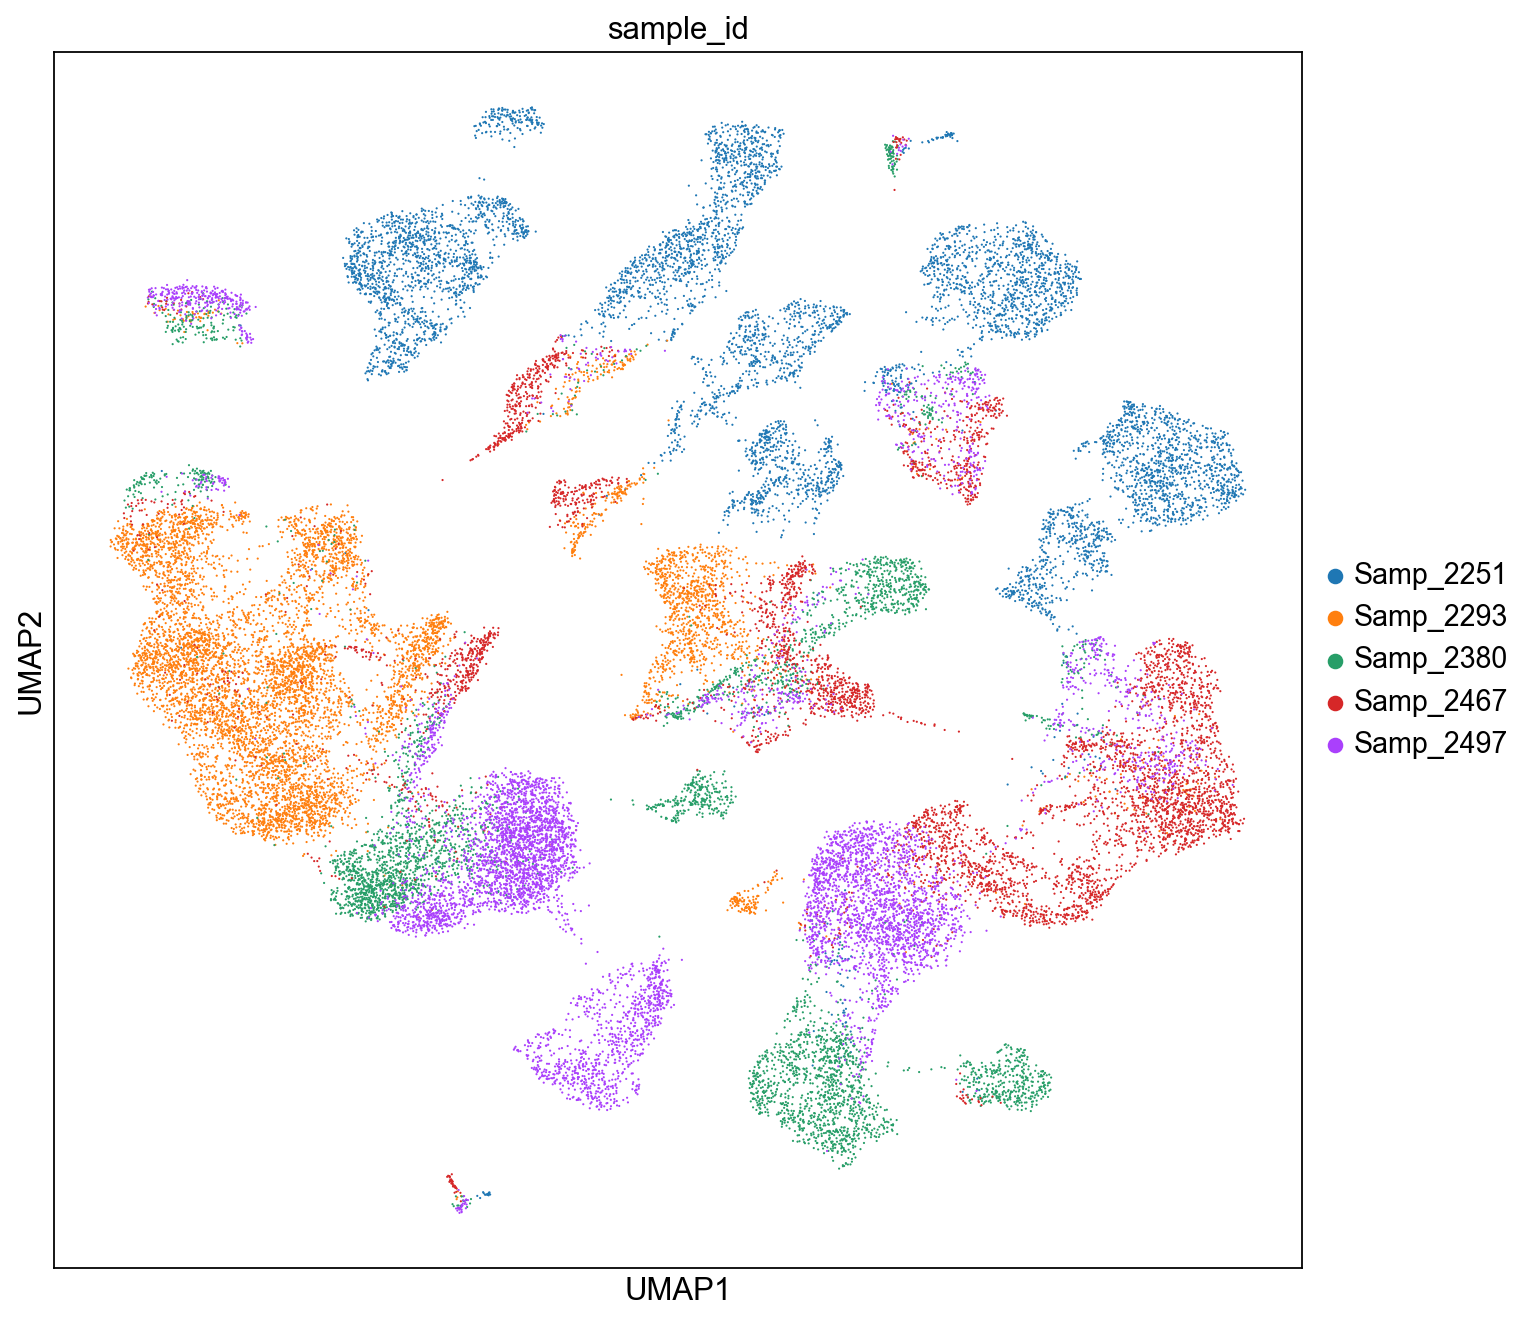

In [33]:
# plot by sample id
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='sample_id')


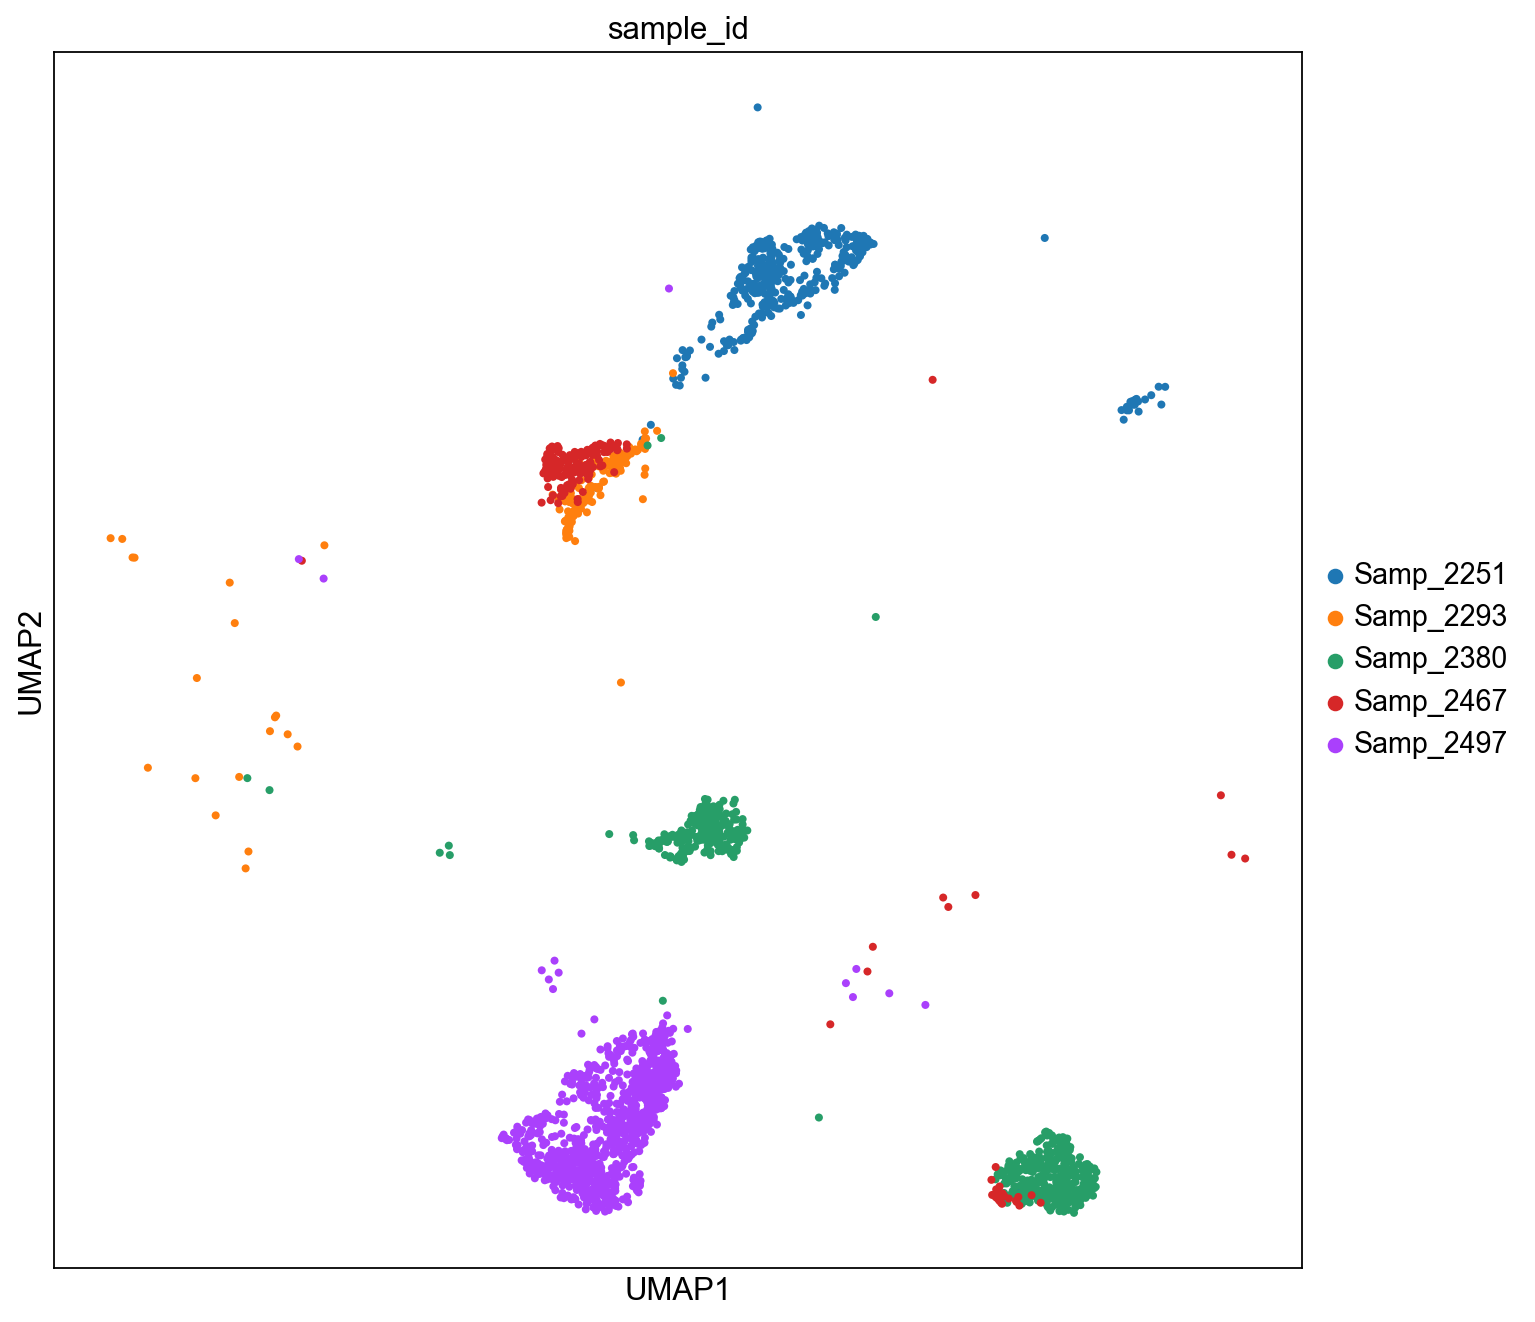

In [35]:
# plot by sample id
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata[np.where(all_adata.obs.celltype_granular == "tumor")[0]], color='sample_id')
